In [1]:
import logging
import ast
from itertools import product
from large_gcs.graph_generators.contact_graph_generator import (
    ContactGraphGeneratorParams,
    ContactGraphGenerator,
)
from large_gcs.algorithms.search_algorithm import AlgMetrics
from large_gcs.graph.graph import Graph, Vertex, Edge
from large_gcs.graph.incremental_contact_graph import IncrementalContactGraph
from large_gcs.graph.contact_graph import ContactGraph
from large_gcs.graph.contact_cost_constraint_factory import (
    contact_shortcut_edge_l2norm_cost_factory_obj_weighted,
    contact_shortcut_edge_l2norm_cost_factory_obj_weighted,
)
from large_gcs.cost_estimators.shortcut_edge_ce import ShortcutEdgeCE

from large_gcs.contact.contact_regions_set import ContactRegionParams

import numpy as np
from copy import deepcopy
from IPython.display import HTML


np.set_printoptions(formatter={"float": lambda x: "{0:0.3f}".format(x)})
logging.basicConfig(level=logging.INFO)
logging.getLogger("large_gcs").setLevel(logging.INFO)
logging.getLogger("drake").setLevel(logging.WARNING)

In [16]:
base_name = "cg_trichal4"
cg_inc = IncrementalContactGraph.load_from_file(
    ContactGraphGeneratorParams.inc_graph_file_path_from_name(base_name),
    should_incl_simul_mode_switches=False,
    should_add_const_edge_cost=True,
    should_add_gcs=True,
    should_use_l1_norm_vertex_cost=True,
)
cg_inc._modes_w_possible_edge_to_target

INFO:large_gcs.graph.contact_graph:Creating vertex costs...
100%|██████████| 2/2 [00:00<00:00, 7928.74it/s]
INFO:large_gcs.graph.graph:Adding 2 vertices to graph...
100%|██████████| 2/2 [00:00<00:00, 20213.51it/s]
INFO:large_gcs.graph.contact_graph:Generating contact pair modes for 3 body pairs...
100%|██████████| 3/3 [00:00<00:00, 43.43it/s]
INFO:large_gcs.graph.incremental_contact_graph:Calculating adjacent contact pair modes (100)
100%|██████████| 100/100 [00:03<00:00, 31.98it/s]


{'IC|obs0_f2-obj0_f1', 'NC|obs0_f2-obj0_f1'}

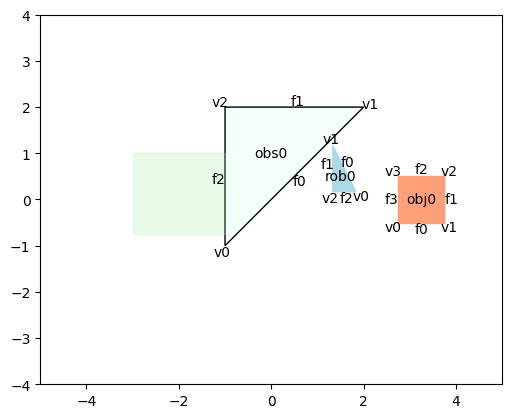

In [17]:
cg_inc.plot()

In [8]:
# This vertex path is a solution
vertex_path=['source', "('NC|obs0_f0-obj0_v3', 'NC|obs0_f0-rob0_v1', 'NC|obj0_f3-rob0_v0')", "('NC|obs0_f0-obj0_v3', 'NC|obs0_f0-rob0_v1', 'NC|obj0_f2-rob0_f2')", "('NC|obs0_f0-obj0_v3', 'NC|obs0_f0-rob0_v1', 'IC|obj0_f1-rob0_f1')", "('IC|obs0_f0-obj0_v3', 'NC|obs0_f0-rob0_v1', 'IC|obj0_f1-rob0_f1')", "('IC|obs0_v0-obj0_f2', 'NC|obs0_f0-rob0_v1', 'IC|obj0_f1-rob0_f1')", "('IC|obs0_f2-obj0_f1', 'NC|obs0_f0-rob0_v1', 'IC|obj0_f1-rob0_f1')", "('IC|obs0_f2-obj0_f1', 'NC|obs0_f0-rob0_v1', 'IC|obj0_f0-rob0_v1')", "('IC|obs0_f2-obj0_f1', 'NC|obs0_v0-rob0_f0', 'IC|obj0_f0-rob0_v1')", 'target']
for v_name in vertex_path:
    print(f"{cg_inc.num_modes_not_adj_to_target(v_name)} modes not adj to target for {v_name}")

0 modes not adj to target for source
1 modes not adj to target for ('NC|obs0_f0-obj0_v3', 'NC|obs0_f0-rob0_v1', 'NC|obj0_f3-rob0_v0')
1 modes not adj to target for ('NC|obs0_f0-obj0_v3', 'NC|obs0_f0-rob0_v1', 'NC|obj0_f2-rob0_f2')
1 modes not adj to target for ('NC|obs0_f0-obj0_v3', 'NC|obs0_f0-rob0_v1', 'IC|obj0_f1-rob0_f1')
1 modes not adj to target for ('IC|obs0_f0-obj0_v3', 'NC|obs0_f0-rob0_v1', 'IC|obj0_f1-rob0_f1')
1 modes not adj to target for ('IC|obs0_v0-obj0_f2', 'NC|obs0_f0-rob0_v1', 'IC|obj0_f1-rob0_f1')
0 modes not adj to target for ('IC|obs0_f2-obj0_f1', 'NC|obs0_f0-rob0_v1', 'IC|obj0_f1-rob0_f1')
0 modes not adj to target for ('IC|obs0_f2-obj0_f1', 'NC|obs0_f0-rob0_v1', 'IC|obj0_f0-rob0_v1')
0 modes not adj to target for ('IC|obs0_f2-obj0_f1', 'NC|obs0_v0-rob0_f0', 'IC|obj0_f0-rob0_v1')
0 modes not adj to target for target


In [18]:
cg_inc._body_pair_to_mode_ids

{('obs0', 'obj0'): ['IC|obs0_f1-obj0_f0',
  'IC|obs0_f2-obj0_f1',
  'IC|obs0_f0-obj0_v3',
  'IC|obs0_v0-obj0_f2',
  'IC|obs0_v1-obj0_f3',
  'NC|obs0_f1-obj0_f0',
  'NC|obs0_f2-obj0_f1',
  'NC|obs0_f0-obj0_v3',
  'NC|obs0_v0-obj0_f2',
  'NC|obs0_v1-obj0_f3'],
 ('obs0', 'rob0'): ['NC|obs0_f1-rob0_f2',
  'NC|obs0_f0-rob0_v1',
  'NC|obs0_f2-rob0_v0',
  'NC|obs0_v0-rob0_f0',
  'NC|obs0_v1-rob0_f1'],
 ('obj0', 'rob0'): ['IC|obj0_f1-rob0_f1',
  'IC|obj0_f2-rob0_f2',
  'IC|obj0_f0-rob0_v1',
  'IC|obj0_f3-rob0_v0',
  'IC|obj0_v0-rob0_f0',
  'NC|obj0_f1-rob0_f1',
  'NC|obj0_f2-rob0_f2',
  'NC|obj0_f0-rob0_v1',
  'NC|obj0_f3-rob0_v0',
  'NC|obj0_v0-rob0_f0']}

In [9]:
base_name = "cg_stackpush_d2"
cg_inc = IncrementalContactGraph.load_from_file(
    ContactGraphGeneratorParams.inc_graph_file_path_from_name(base_name),
    should_incl_simul_mode_switches=False,
    should_add_const_edge_cost=True,
    should_add_gcs=True,
    should_use_l1_norm_vertex_cost=True,
)
cg_inc._modes_w_possible_edge_to_target

INFO:large_gcs.graph.contact_graph:Creating vertex costs...
100%|██████████| 2/2 [00:00<00:00, 8097.11it/s]
INFO:large_gcs.graph.graph:Adding 2 vertices to graph...
100%|██████████| 2/2 [00:00<00:00, 18517.90it/s]
INFO:large_gcs.graph.contact_graph:Generating contact pair modes for 10 body pairs...
100%|██████████| 10/10 [00:00<00:00, 40.30it/s]
INFO:large_gcs.graph.incremental_contact_graph:Calculating adjacent contact pair modes (313)
100%|██████████| 313/313 [00:03<00:00, 98.44it/s] 


{'IC|obs0_f0-obj0_f2',
 'IC|obs0_f0-obj1_f2',
 'IC|obs0_f0-obj2_f2',
 'IC|obs0_f1-obj0_f3',
 'IC|obs0_f1-obj1_f3',
 'IC|obs0_f1-obj2_f3',
 'NC|obs0_f0-obj0_f2',
 'NC|obs0_f0-obj1_f2',
 'NC|obs0_f0-obj2_f2',
 'NC|obs0_f1-obj0_f3',
 'NC|obs0_f1-obj1_f3',
 'NC|obs0_f1-obj2_f3'}

In [10]:
vertex_path = ["source","('NC|obs0_f3-obj0_v1', 'NC|obs0_f3-obj1_v1', 'NC|obs0_f3-obj2_v1', 'NC|obs0_f0-rob0_f2', 'NC|obj0_f1-obj1_f3', 'NC|obj0_f1-obj2_f3', 'NC|obj0_f0-rob0_f2', 'NC|obj1_f1-obj2_f3', 'NC|obj1_f0-rob0_f2', 'NC|obj2_f0-rob0_f2')","('NC|obs0_f3-obj0_v1', 'NC|obs0_f3-obj1_v1', 'NC|obs0_f3-obj2_v1', 'NC|obs0_f3-rob0_v1', 'NC|obj0_f1-obj1_f3', 'NC|obj0_f1-obj2_f3', 'NC|obj0_f0-rob0_f2', 'NC|obj1_f1-obj2_f3', 'NC|obj1_f0-rob0_f2', 'NC|obj2_f0-rob0_f2')","('NC|obs0_f3-obj0_v1', 'NC|obs0_f3-obj1_v1', 'NC|obs0_f3-obj2_v1', 'NC|obs0_f3-rob0_v1', 'NC|obj0_f1-obj1_f3', 'NC|obj0_f1-obj2_f3', 'IC|obj0_f3-rob0_f1', 'NC|obj1_f1-obj2_f3', 'NC|obj1_f0-rob0_f2', 'NC|obj2_f0-rob0_f2')","('IC|obs0_f3-obj0_v1', 'NC|obs0_f3-obj1_v1', 'NC|obs0_f3-obj2_v1', 'NC|obs0_f3-rob0_v1', 'NC|obj0_f1-obj1_f3', 'NC|obj0_f1-obj2_f3', 'IC|obj0_f3-rob0_f1', 'NC|obj1_f1-obj2_f3', 'NC|obj1_f0-rob0_f2', 'NC|obj2_f0-rob0_f2')","('IC|obs0_f3-obj0_v1', 'NC|obs0_f3-obj1_v1', 'NC|obs0_f3-obj2_v1', 'NC|obs0_f3-rob0_v1', 'IC|obj0_f1-obj1_f3', 'NC|obj0_f1-obj2_f3', 'IC|obj0_f3-rob0_f1', 'NC|obj1_f1-obj2_f3', 'NC|obj1_f0-rob0_f2', 'NC|obj2_f0-rob0_f2')","('IC|obs0_f3-obj0_v1', 'IC|obs0_f3-obj1_v1', 'NC|obs0_f3-obj2_v1', 'NC|obs0_f3-rob0_v1', 'IC|obj0_f1-obj1_f3', 'NC|obj0_f1-obj2_f3', 'IC|obj0_f3-rob0_f1', 'NC|obj1_f1-obj2_f3', 'NC|obj1_f0-rob0_f2', 'NC|obj2_f0-rob0_f2')","('IC|obs0_f3-obj0_v1', 'IC|obs0_f3-obj1_v1', 'NC|obs0_f3-obj2_v1', 'NC|obs0_f3-rob0_v1', 'IC|obj0_f1-obj1_f3', 'NC|obj0_f1-obj2_f3', 'IC|obj0_f3-rob0_f1', 'IC|obj1_f1-obj2_f3', 'NC|obj1_f0-rob0_f2', 'NC|obj2_f0-rob0_f2')","('IC|obs0_f3-obj0_v1', 'IC|obs0_f3-obj1_v1', 'IC|obs0_f3-obj2_v1', 'NC|obs0_f3-rob0_v1', 'IC|obj0_f1-obj1_f3', 'NC|obj0_f1-obj2_f3', 'IC|obj0_f3-rob0_f1', 'IC|obj1_f1-obj2_f3', 'NC|obj1_f0-rob0_f2', 'NC|obj2_f0-rob0_f2')","('IC|obs0_f3-obj0_v1', 'IC|obs0_f3-obj1_v1', 'IC|obs0_f2-obj2_f0', 'NC|obs0_f3-rob0_v1', 'IC|obj0_f1-obj1_f3', 'NC|obj0_f1-obj2_f3', 'IC|obj0_f3-rob0_f1', 'IC|obj1_f1-obj2_f3', 'NC|obj1_f0-rob0_f2', 'NC|obj2_f0-rob0_f2')","('IC|obs0_f3-obj0_v1', 'NC|obs0_f2-obj1_f0', 'IC|obs0_f2-obj2_f0', 'NC|obs0_f3-rob0_v1', 'IC|obj0_f1-obj1_f3', 'NC|obj0_f1-obj2_f3', 'IC|obj0_f3-rob0_f1', 'IC|obj1_f1-obj2_f3', 'NC|obj1_f0-rob0_f2', 'NC|obj2_f0-rob0_f2')","('IC|obs0_f3-obj0_v1', 'NC|obs0_f2-obj1_f0', 'NC|obs0_f1-obj2_f3', 'NC|obs0_f3-rob0_v1', 'IC|obj0_f1-obj1_f3', 'NC|obj0_f1-obj2_f3', 'IC|obj0_f3-rob0_f1', 'IC|obj1_f1-obj2_f3', 'NC|obj1_f0-rob0_f2', 'NC|obj2_f0-rob0_f2')","('NC|obs0_f2-obj0_f0', 'NC|obs0_f2-obj1_f0', 'NC|obs0_f1-obj2_f3', 'NC|obs0_f3-rob0_v1', 'IC|obj0_f1-obj1_f3', 'NC|obj0_f1-obj2_f3', 'IC|obj0_f3-rob0_f1', 'IC|obj1_f1-obj2_f3', 'NC|obj1_f0-rob0_f2', 'NC|obj2_f0-rob0_f2')","('NC|obs0_f2-obj0_f0', 'NC|obs0_f2-obj1_f0', 'NC|obs0_f1-obj2_f3', 'NC|obs0_f3-rob0_v1', 'IC|obj0_f1-obj1_f3', 'NC|obj0_f1-obj2_f3', 'IC|obj0_f3-rob0_f1', 'IC|obj1_f1-obj2_f3', 'NC|obj1_f3-rob0_f1', 'NC|obj2_f0-rob0_f2')","('NC|obs0_f2-obj0_f0', 'NC|obs0_f2-obj1_f0', 'NC|obs0_f1-obj2_f3', 'NC|obs0_f3-rob0_v1', 'IC|obj0_f1-obj1_f3', 'NC|obj0_f1-obj2_f3', 'IC|obj0_f3-rob0_f1', 'IC|obj1_f1-obj2_f3', 'NC|obj1_f3-rob0_f1', 'NC|obj2_f3-rob0_f1')","('IC|obs0_f1-obj0_f3', 'NC|obs0_f2-obj1_f0', 'NC|obs0_f1-obj2_f3', 'NC|obs0_f3-rob0_v1', 'IC|obj0_f1-obj1_f3', 'NC|obj0_f1-obj2_f3', 'IC|obj0_f3-rob0_f1', 'IC|obj1_f1-obj2_f3', 'NC|obj1_f3-rob0_f1', 'NC|obj2_f3-rob0_f1')","('IC|obs0_f1-obj0_f3', 'NC|obs0_f2-obj1_f0', 'NC|obs0_f1-obj2_f3', 'NC|obs0_f3-rob0_v1', 'IC|obj0_f1-obj1_f3', 'NC|obj0_f1-obj2_f3', 'IC|obj0_f2-rob0_f0', 'IC|obj1_f1-obj2_f3', 'NC|obj1_f3-rob0_f1', 'NC|obj2_f3-rob0_f1')","('IC|obs0_f1-obj0_f3', 'NC|obs0_f2-obj1_f0', 'NC|obs0_f1-obj2_f3', 'NC|obs0_f2-rob0_f0', 'IC|obj0_f1-obj1_f3', 'NC|obj0_f1-obj2_f3', 'IC|obj0_f2-rob0_f0', 'IC|obj1_f1-obj2_f3', 'NC|obj1_f3-rob0_f1', 'NC|obj2_f3-rob0_f1')","('IC|obs0_f1-obj0_f3', 'NC|obs0_f1-obj1_f3', 'NC|obs0_f1-obj2_f3', 'NC|obs0_f2-rob0_f0', 'IC|obj0_f1-obj1_f3', 'NC|obj0_f1-obj2_f3', 'IC|obj0_f2-rob0_f0', 'IC|obj1_f1-obj2_f3', 'NC|obj1_f3-rob0_f1', 'NC|obj2_f3-rob0_f1')","('IC|obs0_f1-obj0_f3', 'NC|obs0_f1-obj1_f3', 'NC|obs0_f1-obj2_f3', 'NC|obs0_f2-rob0_f0', 'IC|obj0_f1-obj1_f3', 'NC|obj0_f1-obj2_f3', 'IC|obj0_f2-rob0_f0', 'IC|obj1_f1-obj2_f3', 'IC|obj1_f2-rob0_f0', 'NC|obj2_f3-rob0_f1')","('IC|obs0_f1-obj0_f3', 'NC|obs0_f1-obj1_f3', 'NC|obs0_f1-obj2_f3', 'NC|obs0_f2-rob0_f0', 'IC|obj0_f1-obj1_f3', 'NC|obj0_f1-obj2_f3', 'IC|obj0_f2-rob0_f0', 'IC|obj1_f1-obj2_f3', 'IC|obj1_f2-rob0_f0', 'IC|obj2_f2-rob0_f0')","('IC|obs0_f1-obj0_f3', 'NC|obs0_f1-obj1_f3', 'NC|obs0_f1-obj2_f3', 'NC|obs0_f1-rob0_f3', 'IC|obj0_f1-obj1_f3', 'NC|obj0_f1-obj2_f3', 'IC|obj0_f2-rob0_f0', 'IC|obj1_f1-obj2_f3', 'IC|obj1_f2-rob0_f0', 'IC|obj2_f2-rob0_f0')","target"]
for v_name in vertex_path:
    print(f"{cg_inc.num_modes_not_adj_to_target(v_name)} modes not adj to target for {v_name}")

0 modes not adj to target for source
3 modes not adj to target for ('NC|obs0_f3-obj0_v1', 'NC|obs0_f3-obj1_v1', 'NC|obs0_f3-obj2_v1', 'NC|obs0_f0-rob0_f2', 'NC|obj0_f1-obj1_f3', 'NC|obj0_f1-obj2_f3', 'NC|obj0_f0-rob0_f2', 'NC|obj1_f1-obj2_f3', 'NC|obj1_f0-rob0_f2', 'NC|obj2_f0-rob0_f2')
3 modes not adj to target for ('NC|obs0_f3-obj0_v1', 'NC|obs0_f3-obj1_v1', 'NC|obs0_f3-obj2_v1', 'NC|obs0_f3-rob0_v1', 'NC|obj0_f1-obj1_f3', 'NC|obj0_f1-obj2_f3', 'NC|obj0_f0-rob0_f2', 'NC|obj1_f1-obj2_f3', 'NC|obj1_f0-rob0_f2', 'NC|obj2_f0-rob0_f2')
3 modes not adj to target for ('NC|obs0_f3-obj0_v1', 'NC|obs0_f3-obj1_v1', 'NC|obs0_f3-obj2_v1', 'NC|obs0_f3-rob0_v1', 'NC|obj0_f1-obj1_f3', 'NC|obj0_f1-obj2_f3', 'IC|obj0_f3-rob0_f1', 'NC|obj1_f1-obj2_f3', 'NC|obj1_f0-rob0_f2', 'NC|obj2_f0-rob0_f2')
3 modes not adj to target for ('IC|obs0_f3-obj0_v1', 'NC|obs0_f3-obj1_v1', 'NC|obs0_f3-obj2_v1', 'NC|obs0_f3-rob0_v1', 'NC|obj0_f1-obj1_f3', 'NC|obj0_f1-obj2_f3', 'IC|obj0_f3-rob0_f1', 'NC|obj1_f1-obj2_f3', 'NC

In [11]:
base_name = "cg_maze_b1"
cg_inc = IncrementalContactGraph.load_from_file(
    ContactGraphGeneratorParams.inc_graph_file_path_from_name(base_name),
    should_incl_simul_mode_switches=False,
    should_add_const_edge_cost=True,
    should_add_gcs=True,
    should_use_l1_norm_vertex_cost=True,
)
cg_inc._modes_w_possible_edge_to_target

INFO:large_gcs.graph.contact_graph:Creating vertex costs...
100%|██████████| 2/2 [00:00<00:00, 4609.13it/s]
INFO:large_gcs.graph.graph:Adding 2 vertices to graph...
100%|██████████| 2/2 [00:00<00:00, 8330.30it/s]
INFO:large_gcs.graph.contact_graph:Generating contact pair modes for 3 body pairs...
100%|██████████| 3/3 [00:00<00:00, 37.61it/s]
INFO:large_gcs.graph.incremental_contact_graph:Calculating adjacent contact pair modes (151)
100%|██████████| 151/151 [00:03<00:00, 47.79it/s]


{'NC|obs0_f2-obj0_v1', 'NC|obs0_v0-obj0_f1'}

In [12]:
vertex_path = ["source","('NC|obs0_f0-obj0_v3', 'NC|obs0_f1-rob0_v0', 'NC|obj0_f2-rob0_f2')","('NC|obs0_f0-obj0_v3', 'NC|obs0_f1-rob0_v0', 'NC|obj0_f1-rob0_f1')","('NC|obs0_f0-obj0_v3', 'NC|obs0_v1-rob0_f1', 'NC|obj0_f1-rob0_f1')","('NC|obs0_f0-obj0_v3', 'NC|obs0_f0-rob0_v1', 'NC|obj0_f1-rob0_f1')","('NC|obs0_f0-obj0_v3', 'NC|obs0_f0-rob0_v1', 'IC|obj0_f2-rob0_f2')","('NC|obs0_f0-obj0_v3', 'NC|obs0_f0-rob0_v1', 'IC|obj0_f1-rob0_f1')","('NC|obs0_v0-obj0_f2', 'NC|obs0_f0-rob0_v1', 'IC|obj0_f1-rob0_f1')","('NC|obs0_v0-obj0_f2', 'NC|obs0_v0-rob0_f0', 'IC|obj0_f1-rob0_f1')","('NC|obs0_v0-obj0_f2', 'NC|obs0_v0-rob0_f0', 'NC|obj0_f2-rob0_f2')","('NC|obs0_v0-obj0_f2', 'NC|obs0_v0-rob0_f0', 'IC|obj0_f3-rob0_v0')","('NC|obs0_v0-obj0_f2', 'NC|obs0_v0-rob0_f0', 'IC|obj0_v0-rob0_f0')","('IC|obs0_v0-obj0_f1', 'NC|obs0_v0-rob0_f0', 'IC|obj0_v0-rob0_f0')","('IC|obs0_v0-obj0_f1', 'NC|obs0_v0-rob0_f0', 'NC|obj0_f0-rob0_v1')","('NC|obs0_v0-obj0_f1', 'NC|obs0_v0-rob0_f0', 'NC|obj0_f0-rob0_v1')","('NC|obs0_v0-obj0_f1', 'NC|obs0_v0-rob0_f0', 'IC|obj0_f1-rob0_f1')","('NC|obs0_v0-obj0_f1', 'NC|obs0_v0-rob0_f0', 'IC|obj0_f0-rob0_v1')","target"]
for v_name in vertex_path:
    print(f"{cg_inc.num_modes_not_adj_to_target(v_name)} modes not adj to target for {v_name}")

0 modes not adj to target for source
1 modes not adj to target for ('NC|obs0_f0-obj0_v3', 'NC|obs0_f1-rob0_v0', 'NC|obj0_f2-rob0_f2')
1 modes not adj to target for ('NC|obs0_f0-obj0_v3', 'NC|obs0_f1-rob0_v0', 'NC|obj0_f1-rob0_f1')
1 modes not adj to target for ('NC|obs0_f0-obj0_v3', 'NC|obs0_v1-rob0_f1', 'NC|obj0_f1-rob0_f1')
1 modes not adj to target for ('NC|obs0_f0-obj0_v3', 'NC|obs0_f0-rob0_v1', 'NC|obj0_f1-rob0_f1')
1 modes not adj to target for ('NC|obs0_f0-obj0_v3', 'NC|obs0_f0-rob0_v1', 'IC|obj0_f2-rob0_f2')
1 modes not adj to target for ('NC|obs0_f0-obj0_v3', 'NC|obs0_f0-rob0_v1', 'IC|obj0_f1-rob0_f1')
1 modes not adj to target for ('NC|obs0_v0-obj0_f2', 'NC|obs0_f0-rob0_v1', 'IC|obj0_f1-rob0_f1')
1 modes not adj to target for ('NC|obs0_v0-obj0_f2', 'NC|obs0_v0-rob0_f0', 'IC|obj0_f1-rob0_f1')
1 modes not adj to target for ('NC|obs0_v0-obj0_f2', 'NC|obs0_v0-rob0_f0', 'NC|obj0_f2-rob0_f2')
1 modes not adj to target for ('NC|obs0_v0-obj0_f2', 'NC|obs0_v0-rob0_f0', 'IC|obj0_f3-rob

In [13]:
# from large_gcs.algorithms.gcs_star import GcsAstarReachability
# from large_gcs.domination_checkers.reaches_cheaper_sampling import ReachesCheaperSampling


# cost_estimator = ShortcutEdgeCE(cg_inc, contact_shortcut_edge_l2norm_cost_factory_obj_weighted, add_const_cost=True)
# domination_checker = ReachesCheaperSampling(cg_inc, 1)
# alg = GcsAstarReachability(cg_inc, cost_estimator, domination_checker)

# alg.run()